In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from embedding import Embedding
from forward_kinematics import ForwardKinematic
from dynamical_system import DynamicalSystem

# DS

In [2]:
# DS parameters
config_dim = 2
K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)
# config_attractor = np.array([0.9, -0.9])
config_attractor = np.array([1., 0.15])

# Embedding parameters
# x = torch.tensor([[-0.5], [0.8], [0.]])
x = np.array([[-0.6], [1.8], [0.]])[np.newaxis, :]

fk = ForwardKinematic(urdf_file='2_joints_arm.urdf')

joint_limits = [{'lower': -np.pi, 'upper': np.pi}, {'lower': -np.pi, 'upper': np.pi}]
e = Embedding(dimension=2, x=x.repeat(1, 0), fk=fk, limits=joint_limits)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.01)

In [3]:
# start = np.array([-0.55, 0.85])
# start = np.array([-0.19, 0.828])
start = np.array([-0.5, -1.2])
initial_speed = np.array([0., -0.])
q = start
dq = initial_speed
positions = []
frequencies = []
for i in range(0,3000):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')

average execution frequency : 2036.3542 Hz


# FK + Embedding

In [4]:
q1 = np.linspace(joint_limits[0]['lower'], joint_limits[0]['upper'], 100)
q2 = np.linspace(joint_limits[1]['lower'], joint_limits[1]['upper'], 100)
gridX, gridY = np.meshgrid(q1, q2)
grid = np.column_stack((gridX.ravel(), gridY.ravel()))
print(grid.shape)

(10000, 2)


In [5]:
a = np.zeros((grid.shape[0], 3))
freq = []
for i, q in enumerate(grid):
    start = time.time()
    p = e.value_only(q).sum()
    a[i] = np.array([q[0], q[1], p])
    freq.append(1/(time.time() - start))
print(f'average freq : {sum(freq)/len(freq)}')

average freq : 22684.78706597006


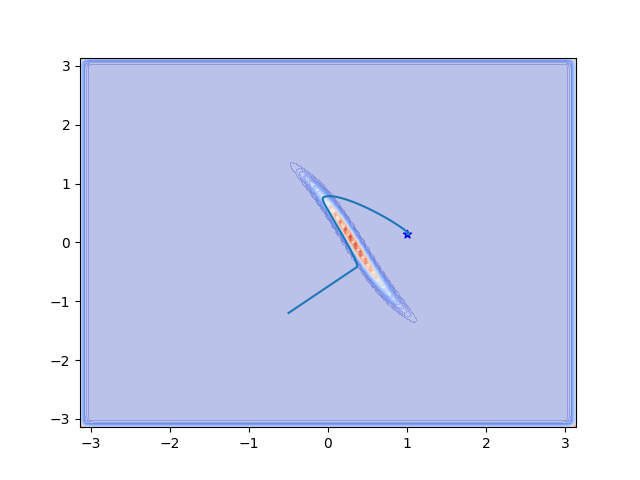

In [6]:
x1 = np.unique(a[:, 0])
x2 = np.unique(a[:, 1])
z = a[:, 2].reshape((x1.shape[0], x2.shape[0]))

ps= np.stack(positions)
%matplotlib widget
plt.figure()
plt.contourf(x1, x2, z, cmap=cm.coolwarm, alpha=0.35, levels=50)
plt.scatter(config_attractor[0], config_attractor[1], label='attractor', marker='*', c='b')
plt.plot(ps[:, 0], ps[:, 1])
plt.xlim([x1.min(), x1.max()])
plt.ylim([x2.min(), x2.max()])
plt.show()

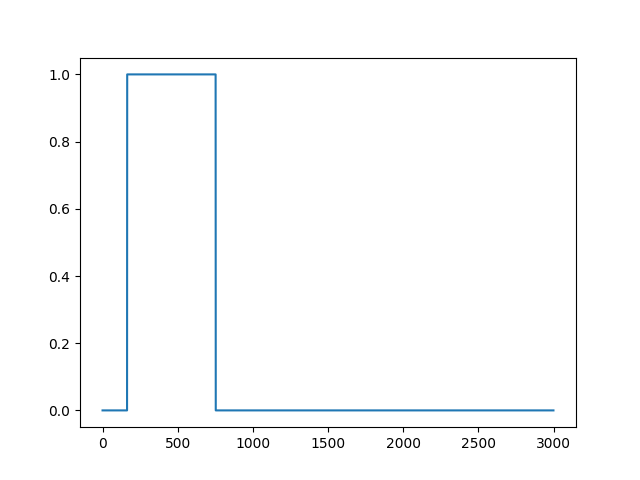

In [7]:
sigma =np.stack(ds.weight_logger)
plt.figure()
plt.plot(range(len(ds.weight_logger)), sigma)
plt.show()